In [1]:
import numpy as np 
import pandas as pd 
import nltk
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
nltk.download('punkt')
np.random.seed(5)

[nltk_data] Downloading package punkt to /home/nicole/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("data/movies.csv")

print(len(df))
df.head()

100


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [3]:
df['plot'] = df['wiki_plot'].astype(str) + '\n' + df['imdb_plot'].astype(str)
df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


In [4]:
# Tokenization - break down articles into sentences or words
sent_tokenized = [sent for sent in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """)]
words_tokenized = [word for word in nltk.word_tokenize(sent_tokenized[0])]

import re
filtered = [word for word in words_tokenized if re.search('[a-zA-Z]', word)]
filtered

['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [5]:
# Stemming - bring down words from its different forms to the root word
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
print("Before stemming: ", filtered)
stemmed_words = [stemmer.stem(word) for word in filtered]
print('After stemming: ', stemmed_words)

Before stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:  ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [6]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [7]:
# Create TfidfVectorizer (Term Frequency-Inverse Document Frequency)
"""
we must convert our textual plot summaries to numbers for the computer 
to be able to extract meaning from them. One simple method of doing this would 
be to count all the occurrences of each word in the entire vocabulary and return 
the counts in a vector.

but consider the word 'the'. 
It appears quite frequently in almost all movie plots and will have a high count in 
each case. But obviously, it isn't the theme of all the movies! 
Term Frequency-Inverse Document Frequency (TF-IDF) is one method which overcomes the 
shortcomings of CountVectorizer. The Term Frequency of a word is the measure of how often 
it appears in a document, while the Inverse Document Frequency is the parameter which 
reduces the importance of a word if it frequently appears in several documents.
"""
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features = 200000,
                                   min_df=0.2, stop_words='english', use_idf=True,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [15]:
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in df['plot']])
print(tfidf_matrix.shape)

/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(100, 564)


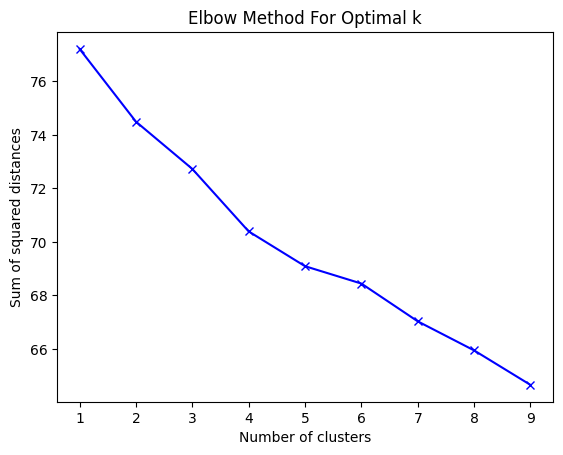

In [16]:
ssd = []
K = range(1, 10)  # Adjust the range of K as needed
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_matrix)  # Make sure this is the correct variable name for your data
    ssd.append(km.inertia_)

# Plot the elbow graph
plt.plot(K, ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/

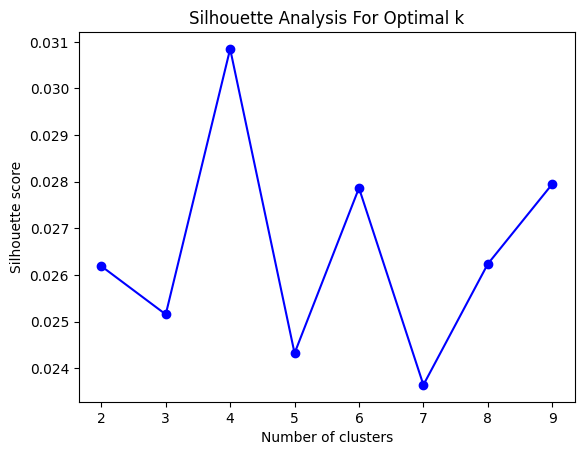

In [17]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 10)  # Silhouette score is only valid with 2 or more clusters

for k in K:
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

In [18]:
km = KMeans(n_clusters=5)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

df['cluster'] = clusters
df['cluster'].value_counts()

/home/nicole/portfolio/movie-similarity/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


cluster
3    45
1    23
4    19
2     9
0     4
Name: count, dtype: int64

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_dist = 1 - cosine_similarity(tfidf_matrix)

In [21]:
similarity_dist.shape

(100, 100)

In [23]:
movie_idx = 0  # For example, 'The Godfather'

# Extract the distances for the movie of interest
movie_distances = similarity_dist[movie_idx]

# Set the distance to itself to be infinity, so it is not considered as the minimum
movie_distances[movie_idx] = np.inf

# Find the index of the movie with the smallest distance
most_similar_movie_idx = np.argmin(movie_distances)

# Retrieve the movie title
most_similar_movie_title = df.loc[most_similar_movie_idx, 'title']

print(f"The most similar movie to {df.loc[movie_idx, 'title']} is {most_similar_movie_title}.")

The most similar movie to The Godfather is The Godfather: Part II.


In [24]:
np.save('artifacts/similarity_dist.npy', similarity_dist)

In [31]:
import matplotlib.pyplot as plt
# Configure matplotlib to display the output inline
%matplotlib inline

# Import modules necessary to plot dendrogram
# ... YOUR CODE FOR TASK 10 ...
from scipy.cluster.hierarchy import linkage, dendrogram

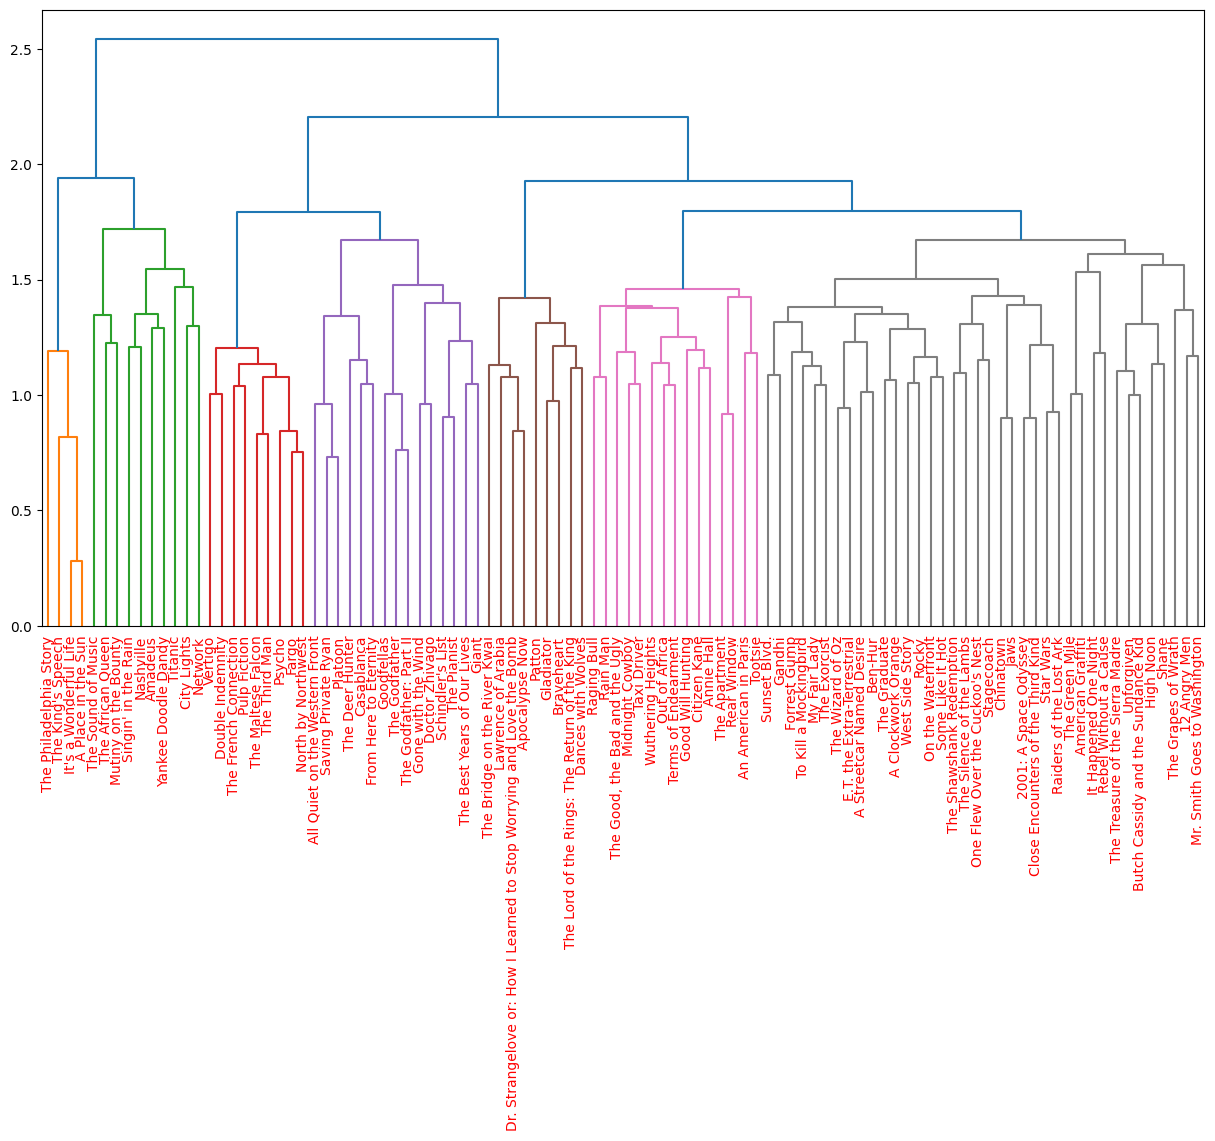

In [49]:
# Create mergings matrix 
mergings = linkage(similarity_dist, method='complete')

# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in df["title"]],
               leaf_rotation=90,
               leaf_font_size=10,
)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(15, 8)

# Show the plotted dendrogram
plt.show()